# Period Change (dpdt)

## Setup

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install "phoebe>=2.4,<2.5"

As always, let's do imports and initialize a new Bundle.

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

b = phoebe.default_binary()

In order to easily differentiate between the components in a light curve and in the orbits, we'll set the  secondary temperature and the mass ratio.

In [3]:
b.set_value('q', 0.8)
b.set_value('teff', component='secondary', value=5000)

and set `dpdt` to an unrealistically large value so that we can easily see the effect over just a few orbits.

In [4]:
b.set_value('per0', 60)
b.set_value('dpdt', 0.005*u.d/u.d)

We'll add several light curve, RV, and orbit datasets, each covering successive cycles of the orbit so that we can differentiate between them later when plotting.

In [5]:
for i in range(3):
    b.add_dataset('lc', compute_phases=phoebe.linspace(i,i+1,101))
    b.add_dataset('rv', compute_phases=phoebe.linspace(i,i+1,101))
    b.add_dataset('orb', compute_phases=phoebe.linspace(i,i+1,101))

It is important to note that the `dpdt` parameter is the time-derivative of `period` (the anomalistic period).  However, the anomalistic and sidereal periods are only different in the case of [apsidal motion](apsidal_motion.ipynb).

In [6]:
print(b.get_parameter(qualifier='dpdt').description)

Time derivative of orbital period (anomalistic), where period is defined at t0@system


## Zero-point for orbital period

The orbital period itself, `period`, is defined at time `t0` (in the system context). If the dataset times are far from `t0@system` then we begin to lose precision on the `period` parameter as a small change, coupled with the propagation of `dpdt * (times - t0)` can cause a large effect.  It is important to try to define the system at a time `t0@system` that are near the dataset times (and near the other [various t0s](t0s.ipynb)).  By default, `t0@system` is set to 0 and we have set our dataset times to start at zero as well.

In [7]:
print(b.filter('t0', context='system'))

ParameterSet: 1 parameters
                        t0@system: 0.0 d


In [8]:
print(b.get_parameter('t0', context='system').description)

Time at which all values are provided.  For values with time-derivatives, this defines their zero-point.


## Considerations in compute_phases and mask_phases

By default, the mapping between [compute_times and compute_phases](compute_times_phases.ipynb) will account for `dpdt`.  In this case, we set `compute_phases` to cover successive orbits... so therefore the resulting `compute_times` will adjust as necessary.

In [9]:
print(b.filter(qualifier='compute_times', kind='lc', context='dataset'))

ParameterSet: 3 parameters
C      compute_times@lc01@dataset: [0.         0.01000025 0.020001   ...
 0.98240493 0.9924543  1.00250417] d
C      compute_times@lc02@dataset: [1.00250417 1.01255455 1.02260543 ...
 1.98983342 1.99993317 2.01003342] d
C      compute_times@lc03@dataset: [2.01003342 2.02013417 2.03023543 ...
 3.00231168 3.01246205 3.02261292] d


For the case of this tutorial, we would rather the `compute_times` be even cycles based on `period` alone, so that we can color by cycles of `period` and easily visualize the effect of `dpdt`.  We could have set `compute_times` directly instead, but then we would need to keep the `period` fixed and know it in advance.  Alternatively, we can set `phases_dpdt = 'none'` to tell this mapping to ignore `dpdt`.

In [10]:
print(b.filter(qualifier='phases_dpdt'))

ParameterSet: 9 parameters
         phases_dpdt@lc01@dataset: dpdt
         phases_dpdt@rv01@dataset: dpdt
        phases_dpdt@orb01@dataset: dpdt
         phases_dpdt@lc02@dataset: dpdt
         phases_dpdt@rv02@dataset: dpdt
        phases_dpdt@orb02@dataset: dpdt
         phases_dpdt@lc03@dataset: dpdt
         phases_dpdt@rv03@dataset: dpdt
        phases_dpdt@orb03@dataset: dpdt


In [11]:
print(b.get_parameter(qualifier='phases_dpdt', dataset='lc01').description)

dpdt to use when converting between compute_times and compute_phases as well as when applying mask_phases


As noted in the description, the `phases_dpdt` parameter will also affect [phase-masking](mask_phases.ipynb).

In [12]:
b.set_value_all('phases_dpdt', 'none')

Now we see that our resulting `compute_times` are direct multiples of the `period` (at `time=t0@system`).

In [13]:
print(b.filter(qualifier='compute_times', kind='lc', context='dataset'))

ParameterSet: 3 parameters
C      compute_times@lc01@dataset: [0.   0.01 0.02 ... 0.98 0.99 1.  ] d
C      compute_times@lc02@dataset: [1.   1.01 1.02 ... 1.98 1.99 2.  ] d
C      compute_times@lc03@dataset: [2.   2.01 2.02 ... 2.98 2.99 3.  ] d


## Contribution to Eclipse Timings in Light Curves

Now we'll run the forward model, but with [light travel time effects](ltte.ipynb) disabled, just to avoid any confusion with small contributions from the finite speed of light.

In [14]:
b.run_compute(ltte=False)

100%|██████████| 301/301 [00:05<00:00, 52.54it/s]


<ParameterSet: 61 parameters | kinds: orb, rv, lc>

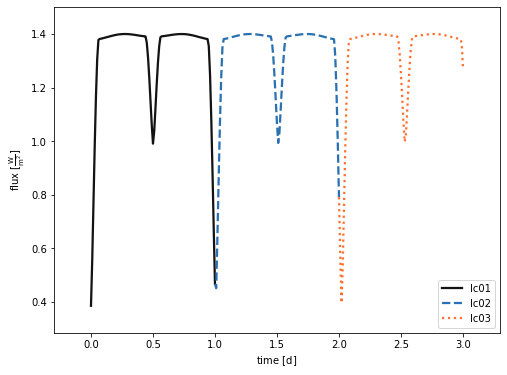

In [15]:
_ = b.plot(kind='lc', x='times', legend=True, show=True)

By default, the phasing in plotting accounts for `dpdt`.

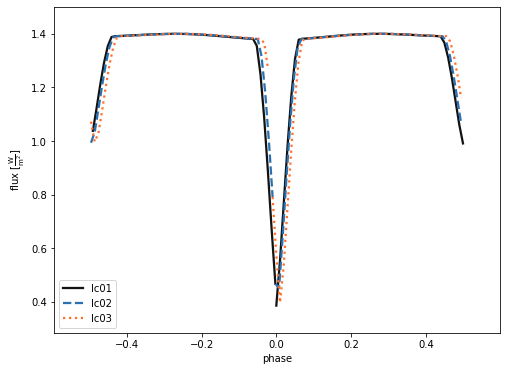

In [16]:
_ = b.plot(kind='lc', x='phases', legend=True, show=True)

To override this behavior, we can pass `dpdt=0.0` so that we can see the eclipses spread across the phase-space.  `dpdt` is passed directly to [b.to_phase](../api/phoebe.frontend.bundle.Bundle.to_phase.md) (see also: [b.to_time](../api/phoebe.frontend.bundle.Bundle.to_time.md) and [b.get_ephemeris](../api/phoebe.frontend.bundle.Bundle.get_ephermis.md))

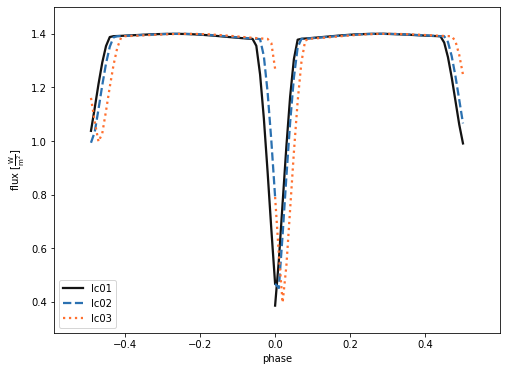

In [17]:
_ = b.plot(kind='lc', x='phases', dpdt=0.0, legend=True, show=True)

## Contribution to Orbits and Mass-Conservation

As the orbital period is instantaneously changing, the instantaneous semi-major axis of the orbit is also adjusted in order to conserve the total mass in the system (under Kepler's third law).  This results in an automatic in or out-spiral of the system whenever `dpdt != 0.0`.  Note that, like the `period`, `sma` is defined at `t0@system`.

Just for visualization purposes, let's rerun our forward model, but this time with an even more exaggerated value for `dpdt`

In [18]:
b.set_value('dpdt', 0.1*u.d/u.d)

In [19]:
b.run_compute(ltte=False)

100%|██████████| 301/301 [00:05<00:00, 58.90it/s]


<ParameterSet: 61 parameters | kinds: orb, rv, lc>

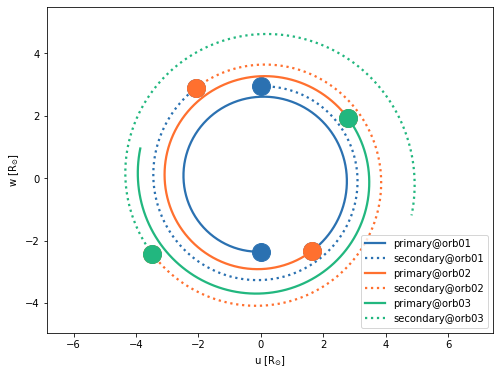

In [20]:
_ = b.plot(kind='orb',
           x='us', y='ws', 
           time=b.get_value('t0_supconj@component')+1*np.arange(0,3), 
           linestyle={'primary': 'solid', 'secondary': 'dotted'}, 
           color={'orb01': 'blue', 'orb02': 'orange', 'orb03': 'green'},
           #color='dataset',  # TODO: we should support this to say color BY dataset
           legend=True,
           show=True)

By plotting `us` vs `times`, we can see the position of the stars at integer periods (when we'd expect eclipses if it weren't for dpdt) as well as the times of the resulting eclipses (when the two stars cross at u=0, ignoring ltte, etc).  Here we clearly see the increasing orbit size as a function of time.

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:4135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif current_value in ['time', 'times'] and 'residuals' in kwargs.values():


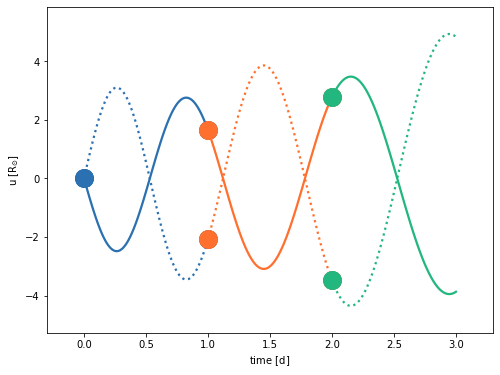

In [21]:
_ = b.plot(kind='orb',
           time=b.get_value('t0_supconj@component')+1*np.arange(0,3), 
           linestyle={'primary': 'solid', 'secondary': 'dotted'}, 
           color={'orb01': 'blue', 'orb02': 'orange', 'orb03': 'green'},
           x='times', y='us',
           show=True)

## Contributions to RVs

Due to the changing size of the orbit due to mass conservation (increasing the RV amplitude for a positive `dpdt`), as well as the changing orbital period (decreasing the RV amplitude for a positive `dpdt`), the RVs will also have a change in amplitude as a function of time (in addition to the phase-effects seen for the light curve above).

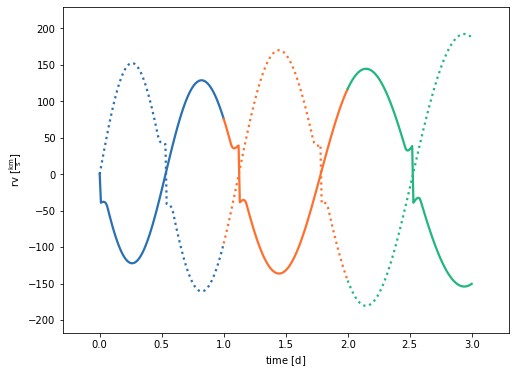

In [22]:
_ = b.plot(kind='rv', x='times', 
           linestyle={'primary': 'solid', 'secondary': 'dotted'}, 
           color={'rv01': 'blue', 'rv02': 'orange', 'rv03': 'green'},
           show=True)